# Introduction


In this homework, you'll be required to load in a dataset which has about 500 features. By using
Lasso ($L^1$) regression, we'll find the optimal constraint on the $L^1$ norm which gives us the best
$R^2$. Then we'll plot the results.

Recall we minimize the following on ** training data: $(x_i,y_i)$**

$$\min_{\beta} \frac{1}{N} \sum_{i=1}^N (y_i - \beta \cdot x_i)^2 + \lambda \|\beta \|_{L^1}.$$


Denoting $\beta_{\lambda}$ as the minimum of the above, we then choose $\lambda$ to maximize $R^2$ on **testing data: $(x_j,y_j)$**

$$ \max_{\lambda} 1 - \frac{\sum_{j} (y_j - \beta_{\lambda} \cdot x_j)^2}{\sum_j (y_j - \bar y)^2}$$


# Lasso Regularization

## Problem 1

a) Load in hw2data.csv from ../data into a pandas dataframe.

b) Set y to be the y variable in the dataframe from a and X to be the remaining features.

c) As shown in the Booking.com example, using Lasso regression, find the regularization strength
which optimizes the $R^2$. 

**Hint:** Take a range of alpha from `np.logspace(-8,-3,1000)`

d) Plot the training perforamnce versus the testing performance, and observe whree the test performance is
maximized. I've written an outline of the code you need.

C:\Users\Asus\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Optimum value of alpha = 0.000660


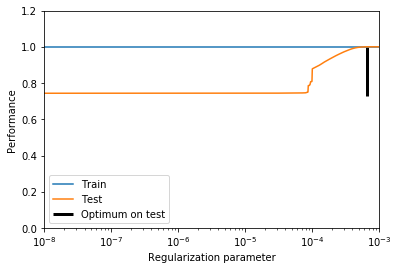

In [76]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import pandas as pd

# load in data
df = pd.read_csv("C:\\Users\\Asus\\Documents\\Grad School\\Intro to Data Science\\APMAE4990-\\data\\hw2data.csv")

# define df vars
y = df['y']
X = df.drop(['y'],1)

# Lasso regression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

# define test range for alphas
alphas = np.logspace(-8,-3,1000)

# split data using train test split, 80% train, 20% split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state = 0)

train_errors=[]
test_errors=[]

# numerically determine which alpha performs best
for i in alphas:
    # perform regression
    lassoReg = Lasso(alpha=i)
    lassoReg.fit(Xtrain,ytrain)
    
    # determine performance
    train_errors.append(lassoReg.score(Xtrain,ytrain))
    test_errors.append(lassoReg.score(Xtest,ytest))

# visualizing alpha vs performance    
#plt.plot(alphas,test_errors)
    
# Compare training and testing performance
alpha_optim_ind = np.argmax(test_errors)
alpha_optim = alphas[alpha_optim_ind]
print('Optimum value of alpha = {:f}'.format(alpha_optim))


plt.semilogx(alphas, train_errors, label='Train')
plt.semilogx(alphas, test_errors, label='Test')
plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',
           linewidth=3, label='Optimum on test')
plt.legend(loc='lower left')
plt.ylim([0,1.2])
plt.xlim([1e-8,1e-3])
plt.xlabel('Regularization parameter')
plt.ylabel('Performance')

plt.show()
#print(np.max(test_errors))
#print(np.min(test_errors))

e) Plot the top coefficients based on this optimal paramter. Why do you think so many are zero? 

Number of coefficients set to 0 = 412


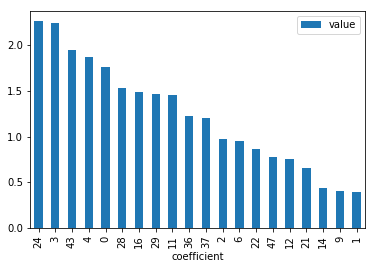

In [89]:
# lasso regression at the optimal alpha value
lassoReg = Lasso(alpha=alpha_optim)
lassoReg.fit(Xtrain, ytrain)

# find number of coefficients that are set to 0
coeffs = pd.DataFrame({'coefficient':range(len(lassoReg.coef_)), 'value':lassoReg.coef_})
numcoeffs = coeffs.index[coeffs['value'] == 0].tolist() #find indeces of zeroed coeffs
print("Number of coefficients set to 0 = {:d}".format(len(numcoeffs)))

# plot the top 20 coefficients
sortedcoeffs = coeffs.sort_values('value',ascending=False).head(20)
sortedcoeffs.plot(x='coefficient',y='value',kind='bar')


Many of the coefficients are set to 0 in this optimization due to the nature of L1 lasso regularization. The constraints set upon the coefficients while minimizing error and maximizing R^2 are such that many of the coefficients quickly converge to 0.

f) Compute the $R^2$ with the optimal coefficient found above on 5 folds using cross_val_score and plot the
results. Does the model work well on all random subsets?

C:\Users\Asus\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


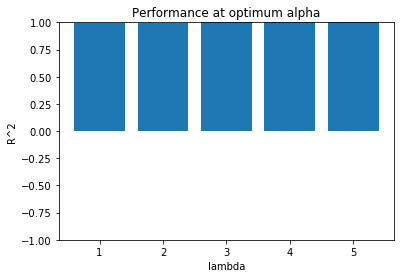

In [104]:
from sklearn.model_selection import cross_val_score

lassoReg = Lasso(alpha=alpha_optim)
r2 = cross_val_score(lassoReg, X, y, cv=5)
plt.ylim([-1,1])
plt.xlabel('lambda')
plt.ylabel('R^2')
plt.title('Performance at optimum alpha')
plt.bar(range(1,6),r2)
plt.show()

Given that our $R^2$ values were very close to 1 throughout the 5 random subsets, we can claim that this model is accurate given alpha is set to its optimal value determined by lasso regularization.

f) Repeat e) but using cross validation. Use error bars on the features which are the standard deviation of the 
coefficiens obtained above. For this problem I"ll walk you through the code. You just need to apply your optimal
$\alpha$ found above. 

In [108]:
from sklearn.cross_validation import KFold
from sklearn import preprocessing

def run_cv_coeffs(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
    coeffs=[]
    # Iterate through folds
    for train_index, test_index in kf:
        
        Xtrain, Xtest = X[train_index], X[test_index]
        ytrain = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(Xtrain,ytrain)
        y_pred[test_index] = clf.predict(Xtest)
        coeffs.append(clf.coef_)
    return coeffs



scaler = preprocessing.StandardScaler()
X_scaled = X.as_matrix().astype(np.float)
X_scaled = scaler.fit_transform(X)

coeffs=run_cv_coeffs(X_scaled,np.array(y),Lasso,alpha=alpha_optim)

C:\Users\Asus\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [109]:
def get_coeffs(coeffs):
    coeffs_avgd = [(coeffs[0][i] + coeffs[1][i] + coeffs[2][i] + coeffs[3][i] + coeffs[4][i])/5 for i in range(0,len(X.columns))]
    coeffs_std = [np.std([coeffs[0][i],coeffs[1][i],coeffs[2][i],coeffs[3][i],coeffs[4][i]]) for i in range(0,len(X.columns))]
    return coeffs_avgd, coeffs_std
coeffs_avg,coeffs_std=get_coeffs(coeffs)

C:\Users\Asus\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


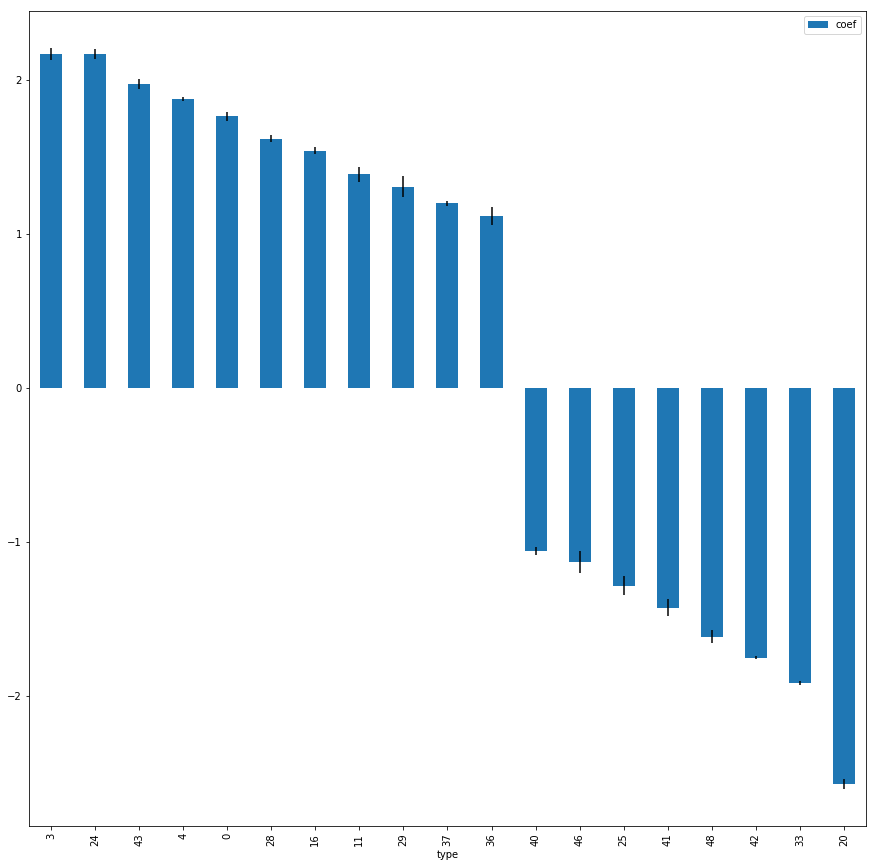

In [110]:
dfCoeffs = pd.DataFrame({'type':X.columns.values, 'coef':coeffs_avg, 'std':coeffs_std})
dfCoeffs = dfCoeffs[(dfCoeffs['coef']>1) |(dfCoeffs['coef']<-1) ]
plt.figure(figsize=(15,15))
dfCoeffs_sorted = dfCoeffs.sort(['coef'])[::-1]
yerr_vals = dfCoeffs_sorted['std'].values
dfCoeffs_sorted.plot(x='type',y='coef',kind='bar',yerr=yerr_vals,figsize=(15,15))